In [1]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import os
import kagglehub
from kagglehub import KaggleDatasetAdapter


c:\Users\syarn\Documents\github_projects\data_science_projects\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = kagglehub.dataset_download("henryshan/google-stock-price")
print("Files:", os.listdir(path))

csv_file = [f for f in os.listdir(path) if f.endswith(".csv")][0]
dataset = pd.read_csv(os.path.join(path, csv_file))

Files: ['GOOG.csv']


### Retrieve only the Open column

In [3]:
df = dataset.loc[:, ["Open"]].values
print(type(df))
df.shape

<class 'numpy.ndarray'>


(4858, 1)

### Plot Open stock price

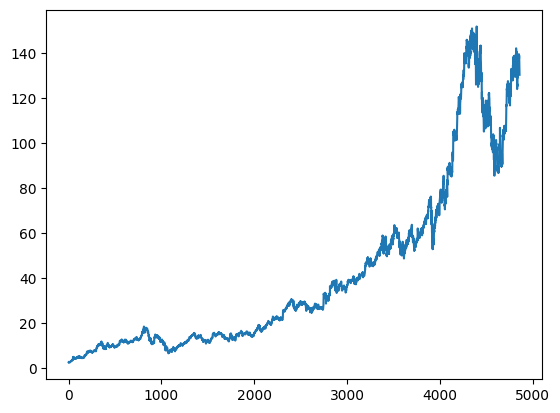

In [4]:
plt.plot(df)
plt.show()

### Scale Data

In [5]:
# Feature Scaling
sc = MinMaxScaler(feature_range=(0,1))

# transform training data
df_scaled = sc.fit_transform(df)

### Set up data into X and y using a sliding window approach for time-series model fitting

In [6]:
def sliding_window(data_array, window_size):
    """
    Description:
    Divides the array of dimension: (n_samples, 1) into X and y using a sliding window

    Parameters:
    data_array(numpy array): The numpy array to split into X and y.
    window_size(int): The window size.

    Returns:
    X: The predicting variable or feature.
    y: The target variable
    """

    # Create X (features) and y (target)
    X, y = [], []
    for i in range(len(data_array) - window_size):
        X.append(data_array[i:i + window_size, 0])  # Extract 50 values
        y.append(data_array[i + window_size, 0])    # 51st value as target

    # Convert to NumPy arrays
    X = np.array(X)
    y = np.array(y)

    # reshape
    # np.reshape(This is the number of training examples (or data points) in the dataset, 
    #           Each sample contains a sequence of 50 values,
    #           This represents the number of features at each time step)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    print("X shape:", X.shape) 
    print("y shape:", y.shape)

    return X, y

In [7]:
window_size=50
X, y = sliding_window(data_array=df_scaled, window_size=window_size)

# split to 80% training and 20% test
train_split = int( len(X) * 0.8)
X_train, X_test = X[:train_split], X[train_split:]
y_train, y_test = y[:train_split], y[train_split:]

X shape: (4808, 50, 1)
y shape: (4808,)


### Set up LTSM architecture

In [8]:
def create_ltsm_model(X_train):
    """
    Description:
    Creates an LTSM model

    Parameters:
    X: (numpy array): The numpy array for training data


    Returns:
    model: LTSM model
    """

    # Define LSTM model
    model = Sequential([
        LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], 1)),  # First LSTM layer
        Dropout(0.3),  # Dropout to prevent overfitting

        LSTM(60, return_sequences=True),  # Second LSTM layer (returns only the last output)
        Dropout(0.3),

        LSTM(60, return_sequences=True),  # Third LSTM layer (returns only the last output)
        Dropout(0.3),

        LSTM(60, return_sequences=False),  #Fourth LSTM layer (returns only the last output)
        Dropout(0.3),

        Dense(1, activation='relu'),  # Fully connected layer
    ])

    # Compile the model
    model.compile(optimizer='adam', 
                  loss='mse', 
                  metrics=['mae'])

    # Display model summary
    model.summary()

    return model

In [9]:
# compile model
model = create_ltsm_model(X_train)

c:\Users\syarn\Documents\github_projects\data_science_projects\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50, 60)         │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50, 60)         │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 50, 60)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 60)             │        29,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 60)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,061 (398.68 KB)

 Trainable params: 102,061 (398.68 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# fit model
model.fit(X_train, y_train, epochs=15, batch_size=32)

Epoch 1/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/step - loss: 0.0019 - mae: 0.0259
Epoch 2/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 5.3498e-04 - mae: 0.0155
Epoch 3/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 5.3153e-04 - mae: 0.0154
Epoch 4/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 4.9119e-04 - mae: 0.0154
Epoch 5/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 48ms/step - loss: 3.7961e-04 - mae: 0.0130
Epoch 6/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - loss: 3.7101e-04 - mae: 0.0131
Epoch 7/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - loss: 3.9285e-04 - mae: 0.0138
Epoch 8/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 2.9360e-04 - mae: 0.0117
Epoch 9/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - loss: 3.4032e-04 - mae: 0.0127
Epoch 10/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step - loss: 3.0308e-04 - mae: 0.0118
Epoch 11/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 2.8810e-04 - mae: 0.0115
Epoch 12/15
121/121 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step -

### Predict

In [11]:
# predict
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# check metrics
results = model.evaluate(X_test, y_test, return_dict=True, verbose=0)
mse = results['loss']
mae = results['mae']
print("MSE:", mse)
print("MAE:", mae)

31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
MSE: 0.0017036979552358389
MAE: 0.033354174345731735


### Plot

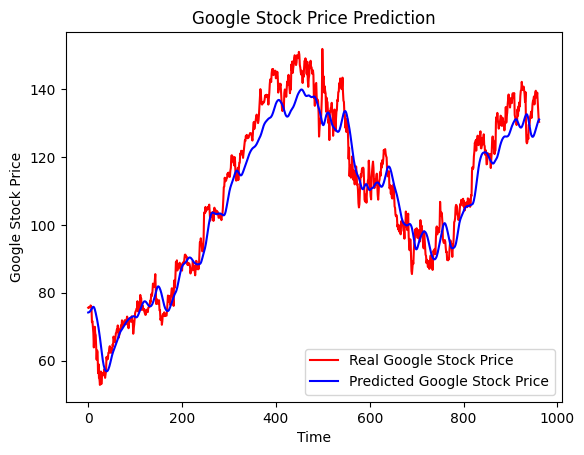

In [12]:

# transform test target variable to original form
y_test = sc.inverse_transform(y_test.reshape(-1, 1))

# visualising the results
plt.plot(y_test, color = "red", label = "Real Google Stock Price")
plt.plot(predicted_stock_price, color = "blue", label = "Predicted Google Stock Price")
plt.title("Google Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Google Stock Price")
plt.legend()
plt.show()